In [16]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,15)
import timeit
from google.colab.patches import cv2_imshow
!pip install gputil
!pip install psutil
!pip install humanize
import keras
import functools
import os,sys,humanize,psutil,GPUtil
import subprocess

In [0]:
## Mish Activation Function
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.log(1+tf.exp(x))))(x)

In [0]:
## Data Parameters for the network
inputShape=(28,28,1)
numClasses=10

In [12]:
##LeNet Architecture
model = Sequential()
model.add(Conv2D(20, 5, padding="same",input_shape=inputShape, activation = mish))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(50, 5, padding="same",activation = mish ))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation = mish))


model.add(Dense(numClasses))

model.add(Activation("softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
__________

In [13]:
#GPU-Info
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
print(subprocess.getoutput('nvidia-smi'))

Tue May 14 13:09:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |   1596MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
## Defining Top-K Accuracy Metric
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

In [15]:
##MNIST Dataset Download
print("Downloading MNIST Dataset")
((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()

##Data Reshaping based on channel orientation
if K.image_data_format() == "channels_first":
	trainData = trainData.reshape((trainData.shape[0], 1, 28, 28))
	testData = testData.reshape((testData.shape[0], 1, 28, 28))
else:
	trainData = trainData.reshape((trainData.shape[0], 28, 28, 1))
	testData = testData.reshape((testData.shape[0], 28, 28, 1))

# scale data to the range of [0, 1]
trainData = trainData.astype("float32") / 255.0
testData = testData.astype("float32") / 255.0

## Generating Data Label Vectors
trainLabels = np_utils.to_categorical(trainLabels, 10)
testLabels = np_utils.to_categorical(testLabels, 10)

In [17]:
#Model Compiling
print("Compiling LeNet")
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy", 'top_k_categorical_accuracy',top3_acc])

##GPU Log file generation
subprocess.Popen("nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats.log",shell=True)

#Training
start_time = timeit.default_timer()
print("Training LeNet")
model.fit(trainData, trainLabels, batch_size=128, epochs=20,verbose=1)
elapsed = timeit.default_timer() - start_time
print("Training Time (in seconds):",elapsed)

#Inference Timing
start_time = timeit.default_timer()
print("Evaluating the Model")
(loss,accuracy,top_5,top_3)=model.evaluate(testData, testLabels,batch_size=128, verbose=1)
print("Test Accuracy:",accuracy*100)
print("Test Loss:",loss*10)
print("Top-5 Accuracy:",top_5*100)
print("Top-3 Accuracy:",top_3*100)
elapsed = timeit.default_timer() - start_time
print("Inference Time (in seconds):",elapsed)


#GPU/CPU Util Function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
#Generate Report
mem_report()


Compiling LeNet
Training LeNet
Epoch 1/20
60000/60000 [==============================] - 4s 68us/step - loss: 1.4091 - acc: 0.6368 - top_k_categorical_accuracy: 0.9020 - top3_acc: 0.8219
Epoch 2/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.2924 - acc: 0.9121 - top_k_categorical_accuracy: 0.9962 - top3_acc: 0.9848
Epoch 3/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.1931 - acc: 0.9427 - top_k_categorical_accuracy: 0.9982 - top3_acc: 0.9920
Epoch 4/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.1443 - acc: 0.9571 - top_k_categorical_accuracy: 0.9989 - top3_acc: 0.9949
Epoch 5/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.1162 - acc: 0.9657 - top_k_categorical_accuracy: 0.9993 - top3_acc: 0.9962
Epoch 6/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.0989 - acc: 0.9702 - top_k_categorical_accuracy: 0.9994 - top3_acc: 0.9969
Epoch 7/20
60000/60000 [=========

In [0]:
## Generation of Activation Maps
from keras import models
layer_outputs = [layer.output for layer in model.layers[:4]] # Extracts the outputs of all the layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [0]:
## Generating the activation map for a input image
img_tensor = trainData[0:1]
activations = activation_model.predict(img_tensor)

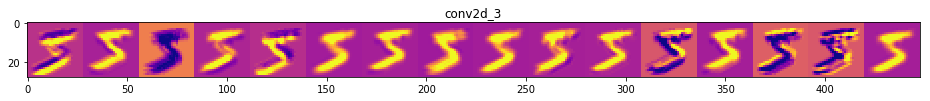

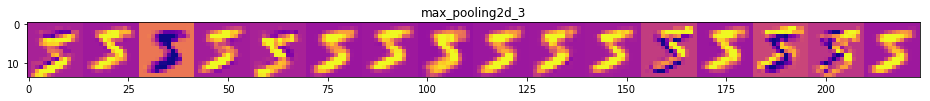

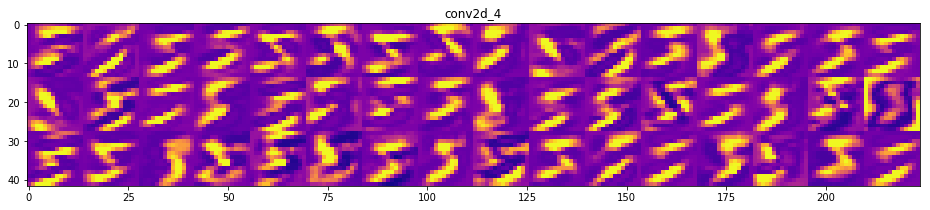

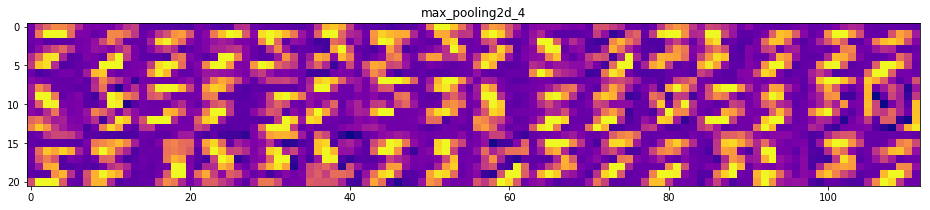

In [20]:
## Visualizing the Hidden Layer Representations
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')

Predicted: 5, Actual: 5


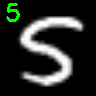

Predicted: 2, Actual: 2


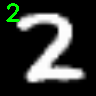

Predicted: 3, Actual: 3


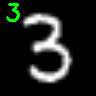

Predicted: 3, Actual: 3


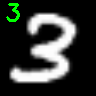

Predicted: 5, Actual: 5


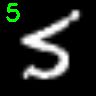

Predicted: 0, Actual: 0


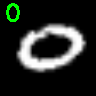

Predicted: 7, Actual: 7


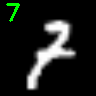

Predicted: 2, Actual: 2


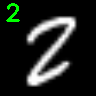

Predicted: 2, Actual: 2


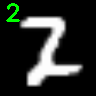

Predicted: 7, Actual: 2


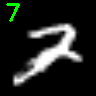

In [21]:
from google.colab.patches import cv2_imshow
# randomly select a few testing digits
for i in np.random.choice(np.arange(0, len(testLabels)), size=(10,)):
	# classify the digit
	probs = model.predict(testData[np.newaxis, i])
	prediction = probs.argmax(axis=1)

	# extract the image from the testData if using "channels_first" ordering
	if K.image_data_format() == "channels_first":
		image = (testData[i][0] * 255).astype("uint8")

	# otherwise we are using "channels_last" ordering
	else:
		image = (testData[i] * 255).astype("uint8")

	# merge the channels into one image
	image = cv2.merge([image] * 3)

	# resize the image from a 28 x 28 image to a 96 x 96 image so we
	# can better see it
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)

	# show the image and prediction
	cv2.putText(image, str(prediction[0]), (5, 20),
				cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
	print("Predicted: {}, Actual: {}".format(prediction[0],
		np.argmax(testLabels[i])))
	cv2_imshow(image)
	cv2.waitKey(0)